In [285]:
# import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



import warnings
warnings.filterwarnings("ignore")

In [286]:
# choose symbols for which to get data from yahoo finance, start and end date of the dataset
# I took some symbols of the famous american companies and american index: S&P 500, Apple, Tesla,
# Ford, Microsoft and Google, Amazon.com Inc., Johnson & Johnson, Pfizer, Exxon, 
# iShares Semiconductor, NVIDIA, Omega Healthcare Investors

symbols = (['SPY', 'AAPL', 'TSLA', 'F', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'PFE', 'XOM','SOXX', 'NVDA', 'OHI'])
start_date = '2000-01-01'
end_date = '2020-10-20'

# downloading data from yahoo finance for the chosen parameters
df = yf.download(symbols, start_date, end_date)

[*********************100%%**********************]  13 of 13 completed


In [287]:
#general descriptive statistics
df[['Adj Close']].describe()

Adj Close                                                      \
              AAPL         AMZN            F        GOOGL          JNJ   
count  5233.000000  5233.000000  5233.000000  4071.000000  5233.000000   
mean     16.423313    22.288674     7.423982    27.053883    60.064824   
std      21.049582    33.468038     2.614189    19.533454    33.390162   
min       0.198599     0.298500     0.744805     2.502753    18.706909   
25%       1.127414     2.075500     5.399777    12.072697    35.568893   
50%       7.578560     6.562500     7.637211    17.295546    42.856487   
75%      24.899622    25.191000     9.061519    40.012501    82.021706   
max     131.624298   176.572495    14.840057    85.869499   142.050400   

                                                                        \
              MSFT         NVDA          OHI          PFE         SOXX   
count  5233.000000  5233.000000  5233.000000  5233.000000  4848.000000   
mean     40.493335    13.271763     9.910194    17.594065    78.805319   
std      40.293108    22.577552     8.159059     7.044409    58.614206   
min      11.327566     0.563453     0.341854     6.358039    19.704201   
25%      18.625362     2.472463     2.898387    12.068614    43.688870   
50%      21.878654     3.645825     7.037214    15.614980    52.389202   
75%      41.545551     7.151636    17.570656    22.881218    84.533360   
max     225.459106   143.112686    32.494923    36.227875   320.772919   

                                              
               SPY         TSLA          XOM  
count  5233.000000  2596.000000  5233.000000  
mean    133.363532    17.200311    43.360046  
std      69.037519    21.755702    15.959156  
min      51.386768     1.053333    15.244629  
25%      83.355560     2.400500    29.765627  
50%     102.058075    14.667666    45.522327  
75%     178.018875    19.879166    57.888676  
max     340.724121   166.106674    69.465523

In [288]:
# Plot stock prices
def plot_data(df, symbols, title='Stock prices', ylabel='Price', y=0 , step=100, ax=None,
              start_date = '2000-01-01', end_date = '2020-10-20'):
    '''Plot stock prices
    INPUT:
    df - Dataframe
    title - title
    ylabel - label of y axis
    y - horizontal line, integer
    step - xticks step, integer
    OUTPUT: plot'''
    
    df1=df[start_date:end_date]
    ax = df1.plot(title=title, figsize=(14,6), ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel(ylabel)
   # ax.axhline(y=y, color='black')
    ax.legend(symbols, loc='upper left')
    try:
        plt.yticks(np.arange(0, df1.max().max()+step, step=step))
    except:
        pass
    plt.show()

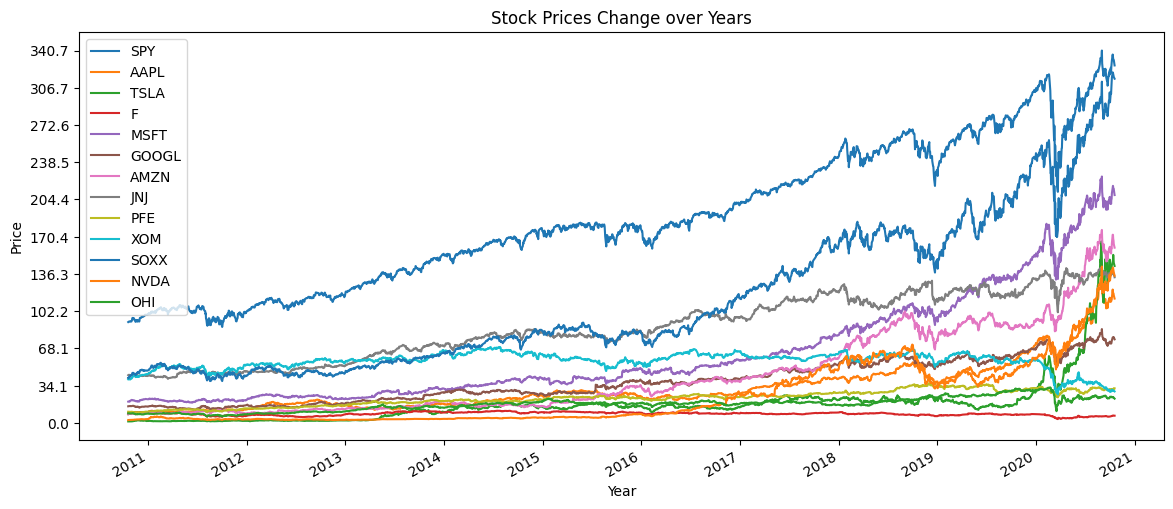

In [294]:
# Plot development of adj close stock prices for chosen companies
symbols = (['SPY', 'AAPL', 'TSLA', 'F', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'PFE', 'XOM','SOXX', 'NVDA', 'OHI'])
plot_data(df['Adj Close'][symbols]['2010-10-20':'2020-10-20'], symbols, title='Stock Prices Change over Years', ylabel='Price', y=0 , step=df['Adj Close'].max().max()/10)

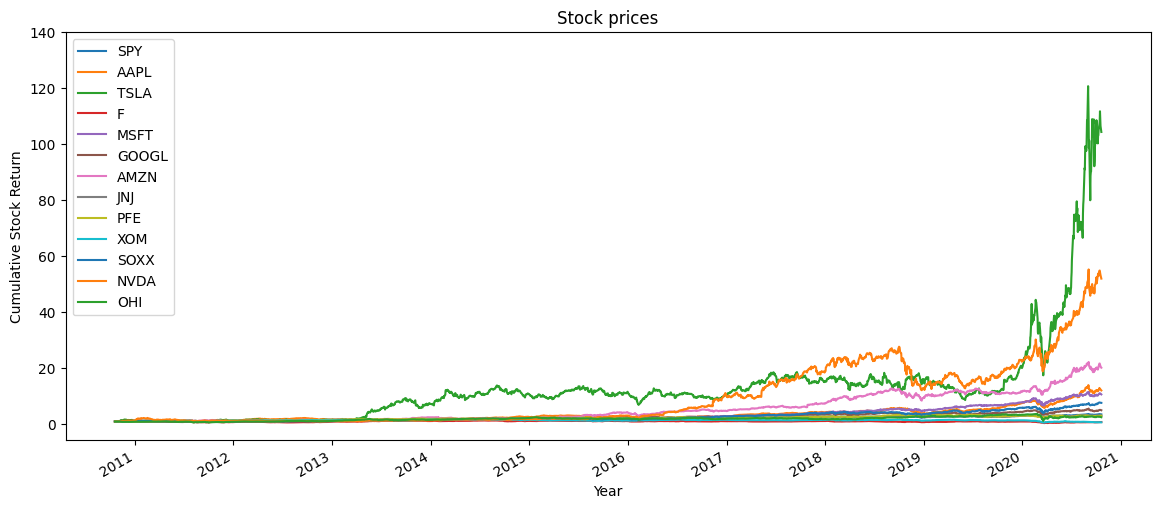

In [295]:
def normalize_data(df):
    '''normalize traiding data
    INPUT df - DataFrame   OUTPUT normalized DataFrame'''
    # In case if one of the stocks didnt exist on the start date  we will not get any line for such a company,
    # for this reason I am filling missing values. It will not bias the cumulative return as the price stays the same.
    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True) 
    return df/df.iloc[0,:]

plot_data(normalize_data(df['Adj Close'][symbols]['2010-10-20':'2020-10-20']), symbols, ylabel='Cumulative Stock Return', step=20, y=1)
plt.show()

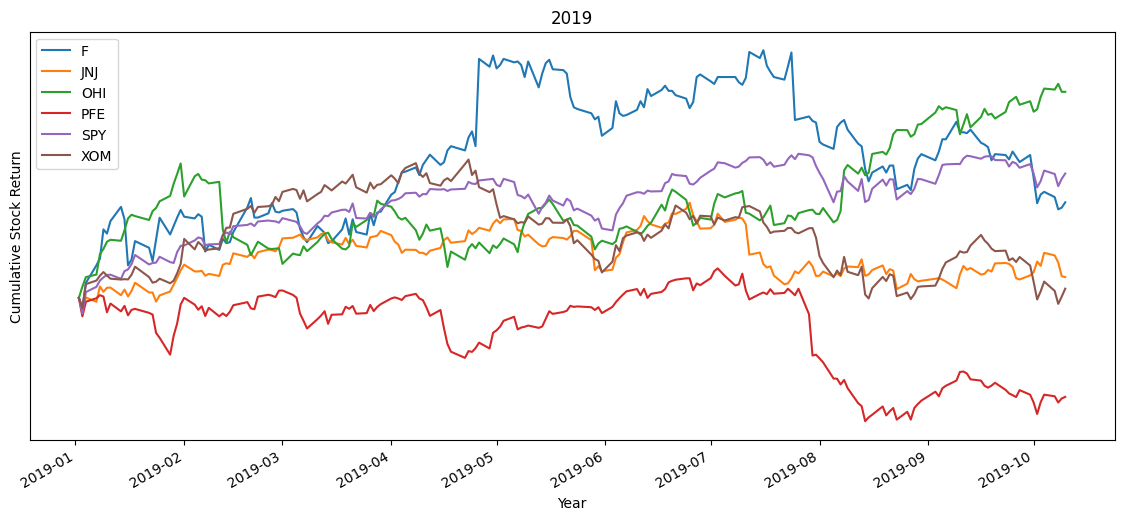

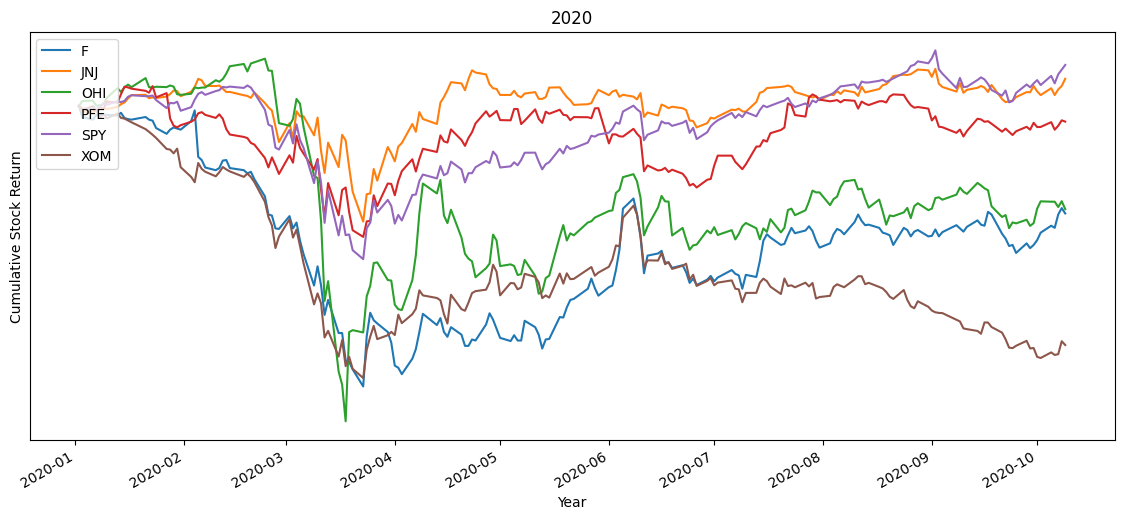

In [297]:
#First, lets look at industry and health care companies
symbols = sorted(['SPY', 'F', 'JNJ', 'PFE', 'XOM', 'OHI'])
plot_data(normalize_data(df['Adj Close'][symbols]['2019-01-01':'2019-10-10']),  symbols, title='2019', ylabel='Cumulative Stock Return',  step=-0.1, y=1, start_date = '2019-01-01', end_date = '2019-10-10')
plt.show()
plot_data(normalize_data(df['Adj Close'][symbols]['2020-01-01':'2020-10-10']),  symbols, title='2020', ylabel='Cumulative Stock Return',  step=-0.1, y=1, start_date = '2020-01-01', end_date = '2020-10-10')
plt.show()

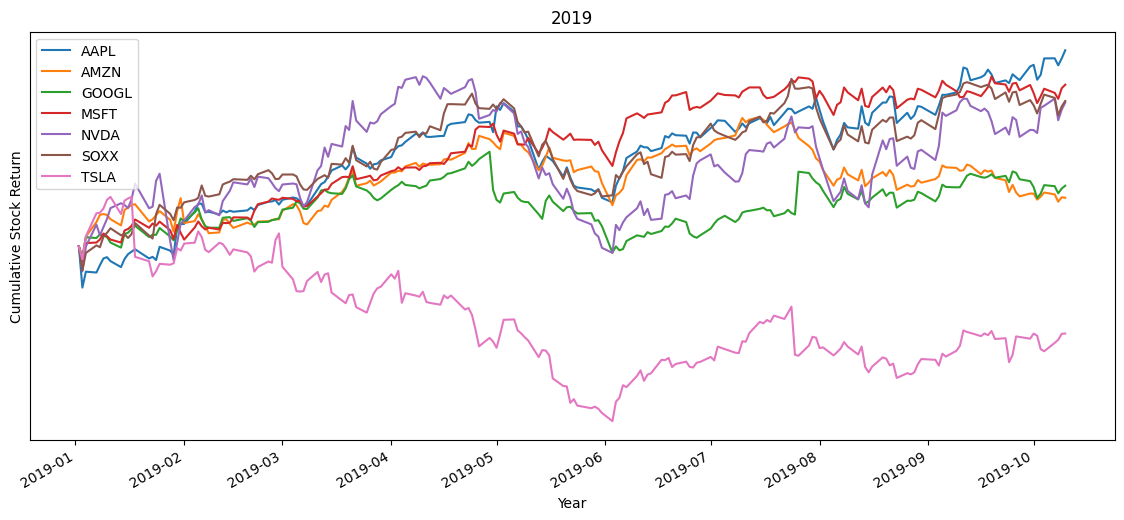

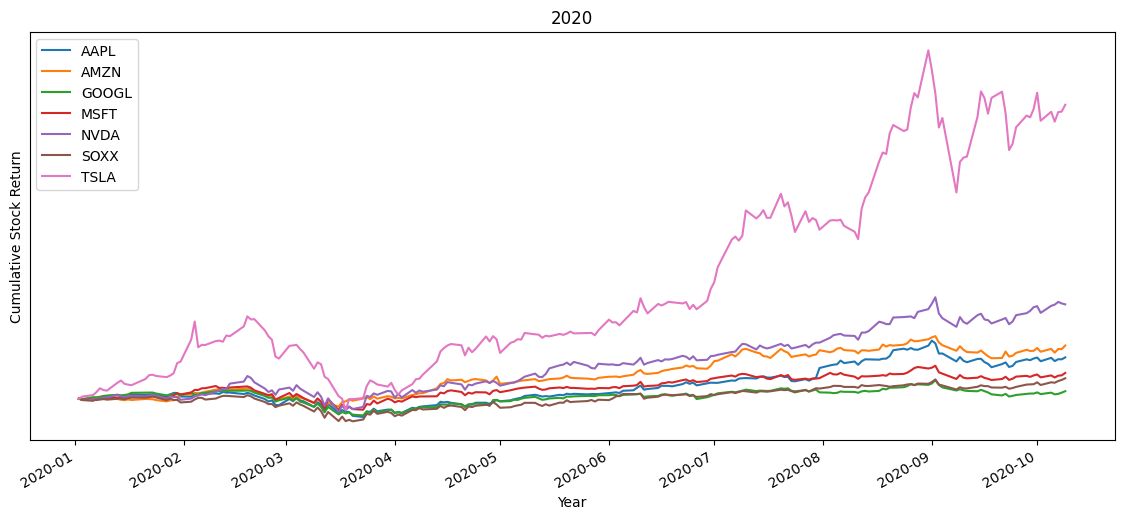

In [298]:
symbols = sorted(['AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'SOXX', 'NVDA'])
plot_data(normalize_data(df['Adj Close'][symbols]['2019-01-01':'2019-10-10']),  symbols, title='2019', ylabel='Cumulative Stock Return',  step=-0.1, y=1, start_date = '2019-01-01', end_date = '2019-10-10')
plt.show()
plot_data(normalize_data(df['Adj Close'][symbols]['2020-01-01':'2020-10-10']),  symbols, title='2020', ylabel='Cumulative Stock Return',  step=-0.1, y=1, start_date = '2020-01-01', end_date = '2020-10-10')
plt.show()

In [299]:
# Plot rolling statistics for a chosen stock Amazon
symbol = 'AMZN'
def rolling_params(df, symbol, price_type, window = 30):
    '''Create rolling mean, rolling standard deviation, upper_band and lower_band of 2 std
    INPUT:
    df - DataFrame
    symbol - stock
    window - how many days - the number of observations used for calculating the statistic
    price_type - type of price for which create rolling parameters
    OUTPUT: rolling mean, rolling standard deviation, upper_band and lower_band of 2 std'''
    
    values = df[(price_type, symbol)]
    rolling_mean = df[(price_type, symbol)].rolling(window=window).mean()
    rolling_std = df[(price_type, symbol)].rolling(window=window).std()
    upper_band = rolling_mean + 2*rolling_std
    lower_band = rolling_mean - 2*rolling_std
    return values, rolling_mean, rolling_std, upper_band, lower_band

        
def plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title = 'Rolling Mean Adj Close 20 {}'.format(symbol)):
    '''Plot rolling mean and uppera and lower bands of a stock
    INPUT:
    symbol - stock
    rolling_mean - rolling 20 days mean of the stock
    upper_band - upper band of the stock
    lower_band
    title - title
    OUTPUT: plot'''
    
    ax = rolling_mean.plot(title=title, figsize=(14,6), label='Rolling Mean')
    plt.plot(upper_band, label='Upper Band')
    plt.plot(lower_band, label='Lower Band')
    plt.plot(values, label='Stock Values')
    ax.set_xlabel('Year')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.show()
    return ax

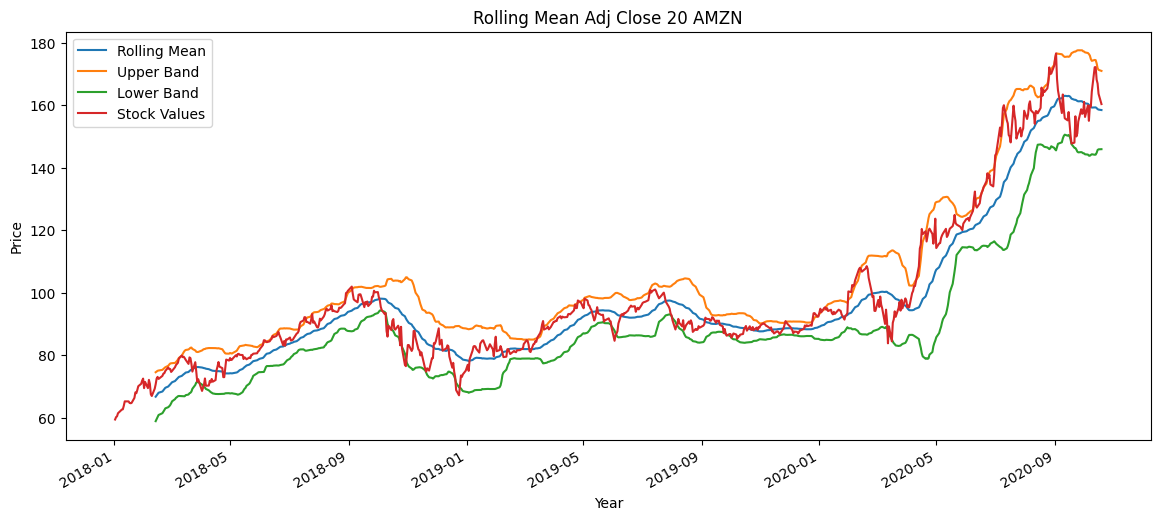

In [303]:
symbol = 'AMZN'
price_type = 'Adj Close'
values, rolling_mean, rolling_std, upper_band, lower_band = rolling_params(df['2018-01-01':'2023-10-10'], symbol, price_type)
plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title='Rolling Mean Adj Close 20 {}'.format(symbol))
plt.show()

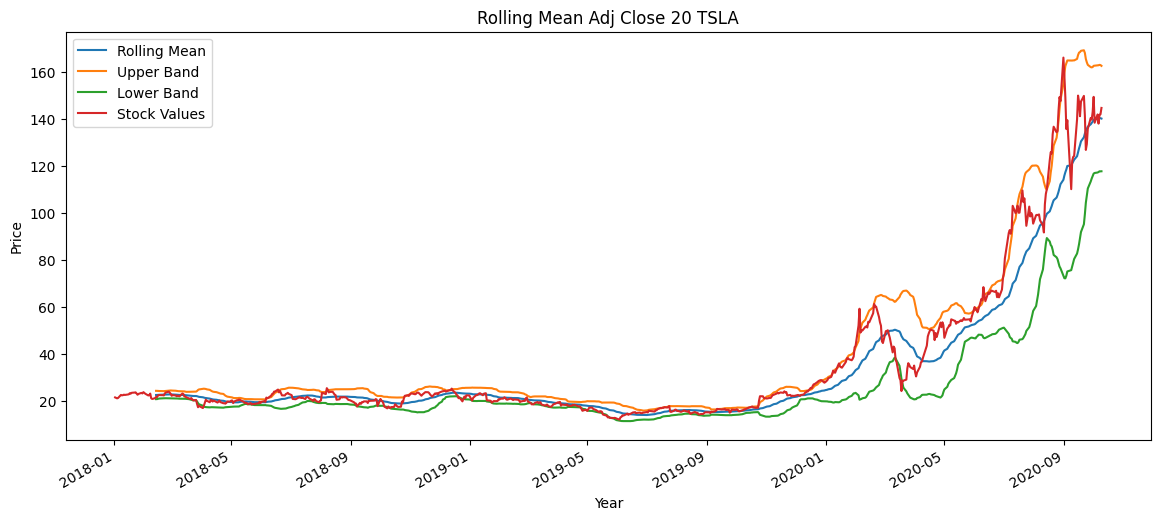

In [304]:
symbol = 'TSLA'
price_type = 'Adj Close'
values, rolling_mean, rolling_std, upper_band, lower_band = rolling_params(df['2018-01-01':'2020-10-10'], symbol, price_type)
plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title='Rolling Mean Adj Close 20 {}'.format(symbol))
plt.show()

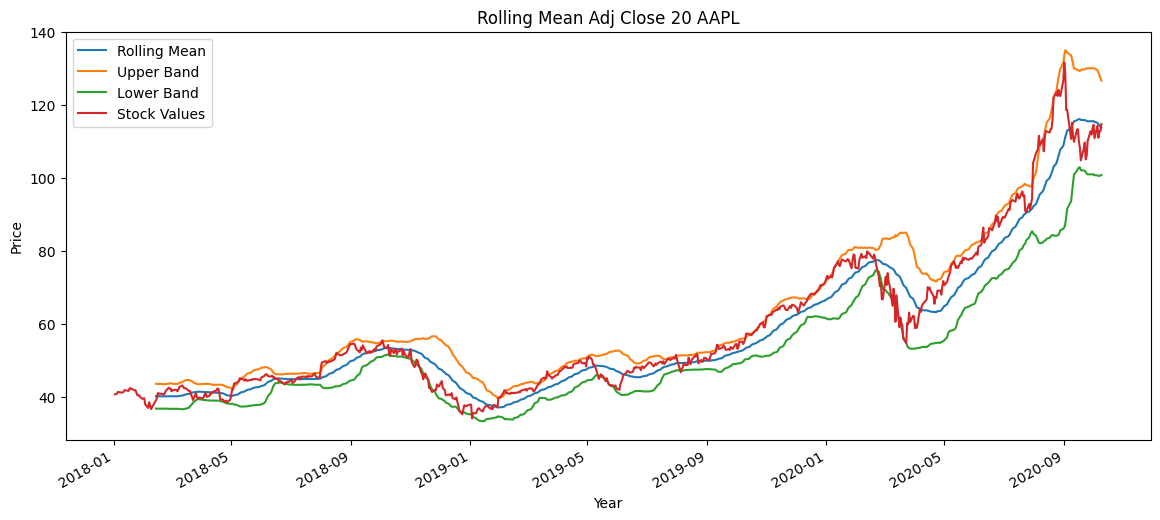

In [305]:
symbol = 'AAPL'
price_type = 'Adj Close'
values, rolling_mean, rolling_std, upper_band, lower_band = rolling_params(df['2018-01-01':'2020-10-10'], symbol, price_type)
plot_rolling(symbol, values, rolling_mean, upper_band, lower_band, title='Rolling Mean Adj Close 20 {}'.format(symbol))
plt.show()

Comparing rolling mean and Bollinger Bands of Amazon and Tesla and Apple we can see that Tesla is by far much more volatile last year.

## MACD - Moving Average Convergence Divergence

Now I would like to show how MACD (Moving Average Convergence Divergence) indicator can help predict if a stock price is going to grow of fall the next days. Divergence in this case representes a difference between two time series and represents MACD. These two time series are rolling exponential weighted means of short time period (I took 12 days) and longer time perios (I took 26). Second is substacted from the first and it is compared with exponential weighted means of even shorter time period (I took 9 days), which is called signal. So buy signal occurs when MACD is smaller than signal line, growing faster than that and line crosses signal line from below. At this point it is a Buy signal. If MACD ist above the signal line, falling faster than that and crosses it from above, it is a Sell signal.

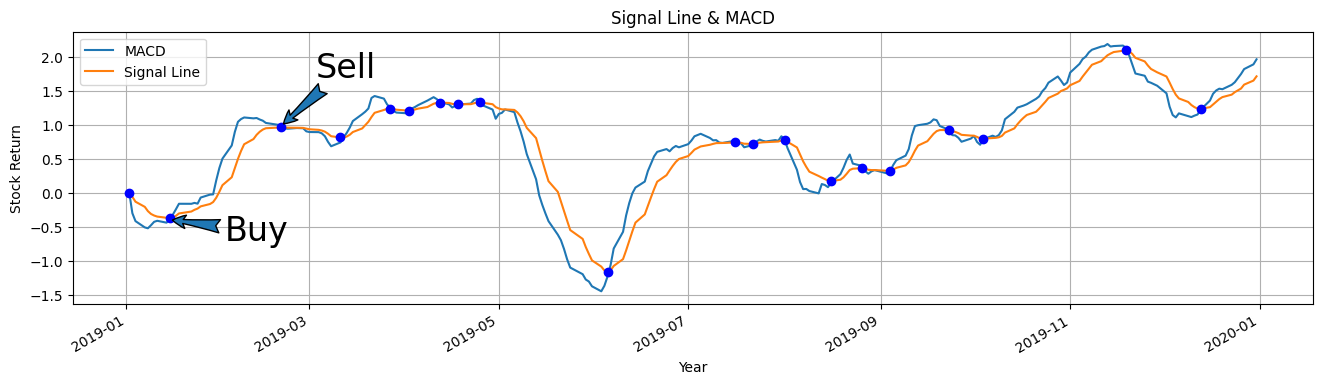

In [352]:
def calc_macd(symbol, price_type = 'Adj Close', high = 26, low = 12, sig = 9, start_date = '2019-01-01', end_date='2020-01-01'):
    '''Create macd, signal
    INPUT:
    symbol - stock
    high - high period EMA, by default 26-period EMA
    low - low period EMA, by default 12-period EMA
    price_type - type of price for which calculate parameters
    start_date - start date as datetime
    end_date - end date as datetime
    OUTPUT: macd, signal'''
 
    values = df[(price_type, symbol)][start_date:end_date]
    macd = (values.ewm(span=low, adjust=False).mean()-values.ewm(span=high, adjust=False).mean())
    signal = macd.ewm(span=sig, adjust=False).mean()
    return macd, signal

macd, signal = calc_macd('AAPL')
macd.plot(label='MACD', figsize=(16,4))
plt.plot(signal, label='Signal Line')
plt.grid(True)
idx = np.argwhere(np.diff(np.sign(signal - macd))).flatten()
plt.plot(macd.index[idx], signal[idx], 'bo')
plt.annotate('Buy', (mdates.date2num(macd.index[9]), macd[9]), xytext=(40, -15), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=24)
plt.annotate('Sell', (mdates.date2num(macd.index[33]), macd[33]), xytext=(25, 35), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=24)
plt.title('Signal Line & MACD')
plt.xlabel('Year')
plt.ylabel('Stock Return')
plt.legend(loc='upper left')
plt.show()

According to MACD we should buy stocks when MACD (blue line) crosses signal line from below and sell them when MACD crosses signal line from above. Looking at the figure above we see that it would indeed work in a lot of cases.


## RSI
Another interesting technique, that could help predict stock prices movements is RSI (relative strength index). It indicates how strong is price momentum shif. It compares average losses and average gains for the previous days. RSI is calculated the following way:

RSI = 100-(100/(1+RS))

where RS is calculated as a propotion from average gain in last 14 days to average loss in last 14 days. So, for example if it was much more loss last days, then a stock is probably goes down and it could be an indicator to sell it. Other way, if it is significantly more gains for the last days than losses, the stock price is growing and it could be a sign to buy it. RSI could be from 0 to 100. Values over 80 represent signal to buy and under 20 a signal to sell. Values in the middle are neutral and dont require for any action. 14 is a common time period used when calculating RSI, even though another time period could be chosen for calculations.

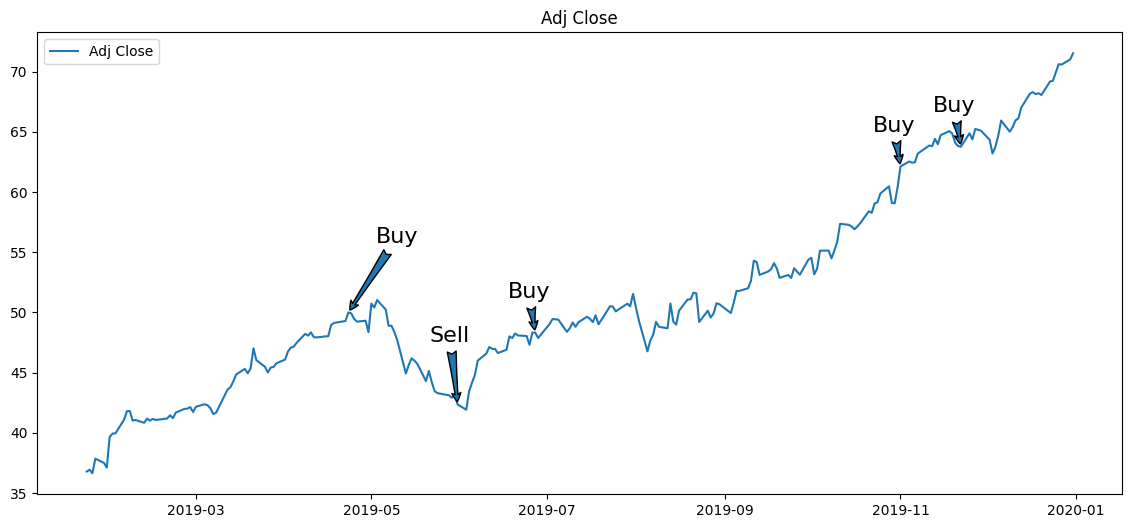

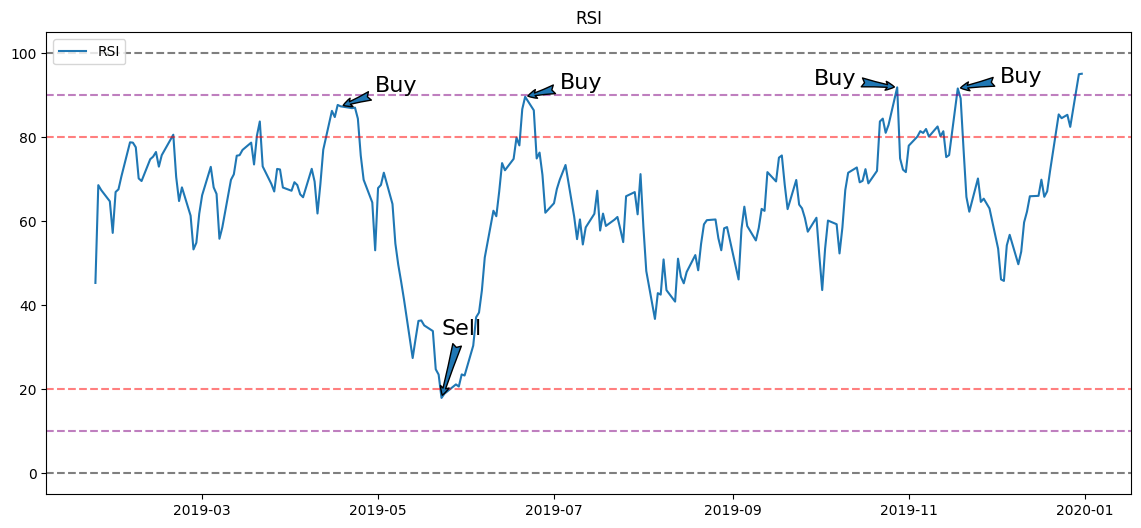

In [308]:
#RSI calculation
def calc_RSI(symbol, price_type = 'Adj Close', time_period = 14, start_date = '2019-01-01', end_date='2020-01-01'):
    '''Calculate RSI
    INPUT:
    symbol - stock
    time_period = tim eperiod for calculation
    price_type - type of price for which calculate parameters
    start_date - start date as datetime
    end_date - end date as datetime
    OUTPUT: macd, signal'''

    delta = df[(price_type, symbol)][start_date:end_date].diff(1)
    gains, losses =  delta.copy(), delta.copy()
    gains[gains < 0] = 0 
    losses[losses > 0] = 0 
    average_gain = gains.rolling(window=time_period).mean()
    average_loss = abs(losses.rolling(window=time_period).mean())
    RS = average_gain / average_loss
    RSI = 100.0 - (100.0/ (1.0 + RS))
    return RSI

RSI = calc_RSI('AAPL')
start_date = '2019-01-01'
end_date = '2020-01-01'
time_period = 14

#Plotting the Adj Close
df1 = df[('Adj Close', 'AAPL')][start_date:end_date].iloc[time_period-1:]
plt.figure(figsize=(14,6))
plt.plot(df1, label = 'Adj Close')
plt.title('Adj Close')
plt.annotate('Buy', (mdates.date2num(df1.index[63]), df1[63]), xytext=(20, 50), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Sell', (mdates.date2num(df1.index[90]), df1[90]), xytext=(-20, 45), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Buy', (mdates.date2num(df1.index[109]), df1[109]), xytext=(-20, 25), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Buy', (mdates.date2num(df1.index[198]), df1[198]), xytext=(-20, 25), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Buy', (mdates.date2num(df1.index[213]), df1[213]), xytext=(-20, 25), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)

plt.legend(loc='upper left')
plt.show()

# RSI
plt.figure(figsize=(14,6))
plt.title('RSI')
plt.plot(RSI, label = 'RSI')
plt.axhline(0, linestyle='--', alpha=0.5, color = 'black')
plt.axhline(10, linestyle='--', alpha=0.5, color = 'purple')
plt.axhline(20, linestyle='--', alpha=0.5, color = 'red')
plt.axhline(80, linestyle='--', alpha=0.5, color = 'red')
plt.axhline(90, linestyle='--', alpha=0.5, color = 'purple')
plt.axhline(100, linestyle='--', alpha=0.5, color = 'black')
plt.annotate('Buy', (mdates.date2num(RSI.index[74]), RSI[74]), xytext=(25, 10), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Sell', (mdates.date2num(RSI.index[98]), RSI[98]), xytext=(0, 45), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Buy', (mdates.date2num(RSI.index[118]), RSI[118]), xytext=(25, 6), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Buy', (mdates.date2num(RSI.index[207]), RSI[207]), xytext=(-60, 2), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)
plt.annotate('Buy', (mdates.date2num(RSI.index[222]), RSI[222]), xytext=(30, 4), 
             textcoords='offset points', arrowprops=dict(arrowstyle='fancy'), fontsize=16)

plt.legend(loc='upper left')
plt.show()

Apple stocks we would indeed get gain in 2019, if we following RSI parameters.

## Prepare data for machine learning

In [309]:
# create a DataFrame for a chosen symbol and fill missing values first forward and then backward, so we can  avoid future bias
symbol = 'AAPL'

def create_ml_df(df, symbol):
    '''This function creates a Dataframe for a given stock and fills it with calculated features
    INPUT:
    df - DataFrame with stock data from yahoo finance
    symbol - true value
    OUTPUT: plot showing the relationship between predicted and true values'''

    ml_df = pd.DataFrame (data = df.iloc[:, df.columns.get_level_values(1)==symbol].values,
                          index = df.iloc[:, df.columns.get_level_values(1)==symbol].index,
                          columns = df.iloc[:, df.columns.get_level_values(1)==symbol].columns.get_level_values(0))

    ml_df.fillna(method='ffill', inplace=True) 
    ml_df.fillna(method='bfill', inplace=True)
    macd, signal = calc_macd(symbol, start_date = ml_df.index[0], end_date = ml_df.index[-1])
    ml_df['MACD'] = macd
    ml_df['Signal'] = signal

    # Add Rolling mean and Rollind std 20 for Adj Close
    ml_df['Rolling Mean Adj Close 20'] = ml_df['Adj Close'].rolling(window=20).mean()
    ml_df['Rolling std Adj Close 20'] = ml_df['Adj Close'].rolling(window=20).std()
    ml_df['Low 14'] = ml_df['Adj Close'].rolling(window=14).min()
    ml_df['High 14'] = ml_df['Adj Close'].rolling(window=14).max()

    # Williams %R - Its purpose is to tell whether a stock or commodity market is trading near the high or the low,
    # or somewhere in between, of its recent trading range.
    ml_df['Williams %R'] = (ml_df['High 14']-ml_df['Adj Close'])/(ml_df['High 14']-100*ml_df['Low 14'])

    # The oscillator is from 100 up to 0. A value of 100 means the close today was the lowest low of the past N days,
    # and 0 means today's close was the highest high of the past N days.
    ml_df['RSI'] = calc_RSI(symbol, start_date = ml_df.index[0], end_date = ml_df.index[-1])
    ml_df['Returns'] = np.log(ml_df['Adj Close'] / ml_df['Adj Close'].shift())
    ml_df.dropna(inplace=True)
    
    return ml_df

## Machine learning 

In [311]:
#Function to plot the comparison between y_pred and y_true
tscv = TimeSeriesSplit() # I am setting cross valudation to take into account that it works with time series data
def plot_results (y_pred , y_test , ylab = 'Return'):
    '''Plot the difference betwenn true and predicted values of the variable
    INPUT:
    y_pred - predicted value
    y_test - true value
    ylab - label of the value variable
    OUTPUT: plot showing the relationship between predicted and true values'''
    
    y_pred = pd.Series(y_pred, index = y_test.index)
    y_pred.plot(title='y_pred versus y_true', figsize=(12,4), label='y_pred')
    y_test.plot(label='y_true')
    plt.xlabel('Year')
    plt.ylabel(ylab)
    plt.legend(loc='upper left')
    plt.show()

## Machine Learning Classifier Model: SVC (Support Vector Classifier)

In [312]:
def mod_svc_lags(ml_df_cut, start_train, end_train, start_test, end_test, lagsnum = 25):
    
    '''Calculate return values for up to 25 previous days, takes their signs as features and building a classifier model. 
    INPUT:
    ml_df_cut - dataset as DataFrame
    start_train - start date for train dataset
    end_train - end date for train dataset
    start_test - start date for test dataset
    end_test - end date for test dataset
    lagsnum - number of days for which calculate return
    OUTPUT: Accuracy of the prediction for each number of features'''
    accuracy_dict = {}
    
    for lags in range(1, lagsnum+1):
        
        ml_df1 = ml_df_cut
        cols = []
        
        for lag in range(1, lags + 1):
            col = 'lag_{}'.format(lag)
            ml_df1[col] = np.sign(ml_df1['Returns'].shift(lag))  
            cols.append(col)
        ml_df1.dropna(inplace=True)

        df_train = ml_df1[start_train: end_train]
        X_train, y_train = df_train[cols],   np.sign(df_train['Returns'])
        df_test = ml_df1[start_test: end_test]
        X_test, y_test = df_test[cols], np.sign(df_test['Returns'])

        model = SVC(gamma='scale')
        model.fit(X_train, np.sign(y_train))
        y_pred = model.predict(X_test)

        accuracy_dict[lags] = model.score(X_test, y_test)*100
        print('Correct Prediction for {} lags:'.format(lags), format(model.score(X_test, y_test)*100, '.2f'), '%')

    print('Mean Accuracy is {}'.format(format(pd.Series([accuracy_dict[k] for k in accuracy_dict]).mean(), '.2f')), '%')

In [313]:
# First estimation
ml_df_svc = create_ml_df(df, 'AAPL')
mod_svc_lags(ml_df_svc, "2010-02-01", "2018-06-30", "2018-07-01", "2018-09-01", lagsnum = 25)

Correct Prediction for 1 lags: 70.45 %
Correct Prediction for 2 lags: 70.45 %
Correct Prediction for 3 lags: 61.36 %
Correct Prediction for 4 lags: 47.73 %
Correct Prediction for 5 lags: 52.27 %
Correct Prediction for 6 lags: 59.09 %
Correct Prediction for 7 lags: 47.73 %
Correct Prediction for 8 lags: 52.27 %
Correct Prediction for 9 lags: 56.82 %
Correct Prediction for 10 lags: 47.73 %
Correct Prediction for 11 lags: 52.27 %
Correct Prediction for 12 lags: 56.82 %
Correct Prediction for 13 lags: 59.09 %
Correct Prediction for 14 lags: 54.55 %
Correct Prediction for 15 lags: 47.73 %
Correct Prediction for 16 lags: 50.00 %
Correct Prediction for 17 lags: 50.00 %
Correct Prediction for 18 lags: 54.55 %
Correct Prediction for 19 lags: 59.09 %
Correct Prediction for 20 lags: 65.91 %
Correct Prediction for 21 lags: 59.09 %
Correct Prediction for 22 lags: 61.36 %
Correct Prediction for 23 lags: 61.36 %
Correct Prediction for 24 lags: 56.82 %
Correct Prediction for 25 lags: 61.36 %
Mean Accu

In [52]:
# Second estimation
ml_df_svc = create_ml_df(df, 'AAPL')
mod_svc_lags(ml_df_svc, "2010-01-01", "2019-09-30", "2019-10-01", "2020-01-01", lagsnum = 50)

Correct Prediction for 1 lags: 64.06 %
Correct Prediction for 2 lags: 53.12 %
Correct Prediction for 3 lags: 48.44 %
Correct Prediction for 4 lags: 67.19 %
Correct Prediction for 5 lags: 62.50 %
Correct Prediction for 6 lags: 65.62 %
Correct Prediction for 7 lags: 60.94 %
Correct Prediction for 8 lags: 60.94 %
Correct Prediction for 9 lags: 56.25 %
Correct Prediction for 10 lags: 59.38 %
Correct Prediction for 11 lags: 56.25 %
Correct Prediction for 12 lags: 57.81 %
Correct Prediction for 13 lags: 64.06 %
Correct Prediction for 14 lags: 71.88 %
Correct Prediction for 15 lags: 75.00 %
Correct Prediction for 16 lags: 64.06 %
Correct Prediction for 17 lags: 70.31 %
Correct Prediction for 18 lags: 65.62 %
Correct Prediction for 19 lags: 64.06 %
Correct Prediction for 20 lags: 62.50 %
Correct Prediction for 21 lags: 65.62 %
Correct Prediction for 22 lags: 57.81 %
Correct Prediction for 23 lags: 59.38 %
Correct Prediction for 24 lags: 56.25 %
Correct Prediction for 25 lags: 51.56 %
Correct P

In [314]:
# Third estimation
mod_svc_lags(ml_df_svc, "2015-01-01", "2019-09-30", "2019-10-01", "2020-01-01", lagsnum = 25)

Correct Prediction for 1 lags: 64.06 %
Correct Prediction for 2 lags: 40.62 %
Correct Prediction for 3 lags: 51.56 %
Correct Prediction for 4 lags: 50.00 %
Correct Prediction for 5 lags: 54.69 %
Correct Prediction for 6 lags: 43.75 %
Correct Prediction for 7 lags: 51.56 %
Correct Prediction for 8 lags: 45.31 %
Correct Prediction for 9 lags: 51.56 %
Correct Prediction for 10 lags: 51.56 %
Correct Prediction for 11 lags: 56.25 %
Correct Prediction for 12 lags: 60.94 %
Correct Prediction for 13 lags: 60.94 %
Correct Prediction for 14 lags: 64.06 %
Correct Prediction for 15 lags: 62.50 %
Correct Prediction for 16 lags: 54.69 %
Correct Prediction for 17 lags: 57.81 %
Correct Prediction for 18 lags: 59.38 %
Correct Prediction for 19 lags: 54.69 %
Correct Prediction for 20 lags: 57.81 %
Correct Prediction for 21 lags: 53.12 %
Correct Prediction for 22 lags: 56.25 %
Correct Prediction for 23 lags: 54.69 %
Correct Prediction for 24 lags: 54.69 %
Correct Prediction for 25 lags: 59.38 %
Mean Accu

Comparing first and third estimations we can see that less data doesnt mean less predictive power in our case. I also would like to conclude that the accuracy score is quite unstable and not much higher that 50% random choise so that I using this method to predict stock prices doesnt have much value. Now I would like to use the trading parameters ('MACD', 'Signal', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20', 'Low 14', 'High 14', 'Williams %R', 'RSI') I calculated before as features and look if it makes my predictions better and also look at the combination of the both types of features.

In [315]:
ml_df = create_ml_df(df, 'AAPL')
# Function for SVC ML model
def mod_svc(ml_df, start_train, end_train, start_test, end_test, features):
    
        df_train = ml_df[start_train: end_train]
        X_train, y_train = df_train[features], np.sign(df_train['Returns'])

        df_test = ml_df[start_test: end_test]
        X_test, y_test = df_test[features], np.sign(df_test['Returns'])

        model = SVC(gamma='scale')
        model.fit(X_train, np.sign(y_train))
        y_pred = model.predict(X_test)

        print('Accuracy Prediction:', format(model.score(X_test, y_test)*100, '.2f'), '%')  

In [316]:
features = ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']
mod_svc(ml_df, "2014-01-01", "2018-09-30", "2018-10-01", "2019-01-01", features)
mod_svc(ml_df, "2011-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_svc(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
mod_svc(ml_df, "2010-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

Accuracy Prediction: 68.25 %
Accuracy Prediction: 53.97 %
Accuracy Prediction: 65.62 %
Accuracy Prediction: 65.62 %


In [317]:
features = ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R',
           'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10']
mod_svc(ml_df_svc, "2014-01-01", "2018-09-30", "2018-10-01", "2019-01-01", features)
mod_svc(ml_df_svc, "2011-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_svc(ml_df_svc, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
mod_svc(ml_df_svc, "2010-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

Accuracy Prediction: 66.67 %
Accuracy Prediction: 55.56 %
Accuracy Prediction: 65.62 %
Accuracy Prediction: 65.62 %


In [320]:
print(ml_df.head())

            Adj Close     Close      High       Low      Open       Volume  \
Date                                                                         
2000-01-31   0.785239  0.926339  0.927455  0.843750  0.901786  701680000.0   
2000-02-01   0.758749  0.895089  0.937500  0.892857  0.928571  318035200.0   
2000-02-02   0.747869  0.882254  0.911830  0.866071  0.899554  464195200.0   
2000-02-03   0.781928  0.922433  0.930804  0.895089  0.895647  475193600.0   
2000-02-04   0.817406  0.964286  0.982143  0.925223  0.928013  425320000.0   

                MACD    Signal  Rolling Mean Adj Close 20  \
Date                                                        
2000-01-31 -0.002047 -0.005810                   0.782283   
2000-02-01 -0.005311 -0.005711                   0.777860   
2000-02-02 -0.008677 -0.006304                   0.776464   
2000-02-03 -0.008497 -0.006743                   0.776204   
2000-02-04 -0.005430 -0.006480                   0.781124   

            Rolling std A

Predictive power is not very high, but still at least higher than random choice for all the stocks and reaching more then 70%for some of them, so it is still a win!

## Random Forest Classifier

In [321]:
ml_df = create_ml_df(df, 'AAPL')
def mod_rfc(ml_df, start_train, end_train, start_test, end_test, features, print_acc = True):
    
        df_train = ml_df[start_train: end_train]
        X_train, y_train = df_train[features], np.sign(df_train['Returns'])
        df_test = ml_df[start_test: end_test]
        X_test, y_test = df_test[features], np.sign(df_test['Returns'])

        model = RandomForestClassifier(max_depth=2, random_state=0)
        model.fit(X_train, np.sign(y_train))
        y_pred = model.predict(X_test)
        
        if print_acc==True:
            print('Accuracy of Stock Prediction for : ', start_train, ' - ', end_train, ' - ', start_test, ' - ',
                  end_test, '\n', format(model.score(X_test, y_test)*100, '.2f'), '%')
        return model.score(X_test, y_test)*100

I would like to look if additional lag values or more data increase predictive power of classifier.

In [322]:
#First, let's take only trading parameters
features = ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']
print('Accuracy of Stock Prediction for: ', features, '\n')

mod_rfc(ml_df, "2014-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_rfc(ml_df, "2012-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)
mod_rfc(ml_df, "2014-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)

#Second, let's add 5 features of lag values 
features = ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R',
           'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
print('Accuracy of Stock Prediction for: ', features, '\n')

mod_rfc(ml_df_svc, "2014-01-01", "2016-09-30", "2016-10-01", "2017-01-01", features)
mod_rfc(ml_df_svc, "2012-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)
mod_rfc(ml_df_svc, "2014-01-01", "2020-07-31", "2020-08-01", "2020-10-01", features)

Accuracy of Stock Prediction for:  ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R'] 

Accuracy of Stock Prediction for :  2014-01-01  -  2016-09-30  -  2016-10-01  -  2017-01-01 
 76.19 %
Accuracy of Stock Prediction for :  2012-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %
Accuracy of Stock Prediction for :  2014-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %
Accuracy of Stock Prediction for:  ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'] 

Accuracy of Stock Prediction for :  2014-01-01  -  2016-09-30  -  2016-10-01  -  2017-01-01 
 76.19 %
Accuracy of Stock Prediction for :  2012-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %
Accuracy of Stock Prediction for :  2014-01-01  -  2020-07-31  -  2020-08-01  -  2020-10-01 
 74.42 %


74.4186046511628

Scores look good. Now, I would like to test the performance of my model. For that I first wrote a function that would generate random start/end dates for trainig and testing date (of cause making sure that test data is always in future in regard to train data). Then I am perform a 50 loop and count mean and standard deviation of accuracy score of the model.

In [330]:
# This function will create  random dates

start_date = datetime.date(2000, 1, 1)
end_date = datetime.date(2020, 10, 20)

def rand_dates(start_date, end_date): 
    
    random_number_of_days = random.randrange((end_date - start_date).days -10)
    random_date_start_train = start_date + datetime.timedelta(days=random_number_of_days)
    random_number_of_days1 = random.randrange((end_date - random_date_start_train).days - 6)
    
    random_date_end_train = random_date_start_train + datetime.timedelta(days=random_number_of_days1)
    random_date_start_test = random_date_end_train + datetime.timedelta(days=1)
    random_number_of_days2 = random.randrange((end_date - random_date_start_test).days - 3)
    
    random_date_end_test = random_date_start_test + datetime.timedelta(days=random_number_of_days2)
    
    random_date_start_train = pd.to_datetime(random_date_start_train,format='%Y/%m/%d') 
    random_date_end_train = pd.to_datetime(random_date_end_train,format='%Y/%m/%d') 
    random_date_start_test = pd.to_datetime(random_date_start_test,format='%Y/%m/%d') 
    random_date_end_test = pd.to_datetime(random_date_end_test,format='%Y/%m/%d') 
    
    return random_date_start_train, random_date_end_train, random_date_start_test, random_date_end_test


In [331]:
features = ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']

acc = []
for i in tqdm(range(1, 50)):
    random_date_start_train, random_date_end_train, random_date_start_test, random_date_end_test = rand_dates(start_date, end_date)
    acc_i = mod_rfc(ml_df, random_date_start_train, random_date_end_train, random_date_start_test,
                  random_date_end_test, features, print_acc=False)
    acc.append(acc_i)
    
acc_mean = np.mean(np.array(acc))
acc_std = np.std(np.array(acc))
print('Mean of Accuracy: ', acc_mean, 'Std of Accuracy: ', acc_std)

100%|███████████████████████████████████████████| 49/49 [00:10<00:00,  4.83it/s]

Mean of Accuracy:  68.91795684301005 Std of Accuracy:  5.266828127040676



As Random Forest Classifier shown very good results! By testing 50 loops the accuracy is significantly highes then 50%.

# Machine Learning Regressor models

In [339]:
#First I would like to write a function to make a train/test split for a given data
ml_df = create_ml_df(df, 'AAPL')
features = ['MACD', 'Signal', 'Rolling Mean Adj Close 20', 'Rolling std Adj Close 20', 'RSI', 'Williams %R']

def test_train_split(ml_df, start_train, end_train, start_test, end_test, features):
    '''Split dataset in train and test
    INPUT:
    ml_df - dataset as DataFrame
    start_train - start date for train dataset
    end_train - end date for train dataset
    start_test - start date for test dataset
    end_test - end date for test dataset
    OUTPUT: Features datasets and variable of interest for train and test datasets'''
    
    df_train = ml_df[start_train: end_train]
    df_test = ml_df[start_test: end_test]

    X_train = df_train[features]
    y_train = df_train['Returns']
    X_test = df_test[features]
    y_test = df_test['Returns']
    
    return X_train, y_train, X_test, y_test

# And as the second step I wrote a function, that takes train/test data, scaler (if needed) and machine learning model as input
# and predicts values of the variable of interest. Using this model I can quickly evaluate predictive power of different ML models

def ml_model(X_train, y_train, X_test, y_test, ml_mod, scal = None):
    '''Model for given features and variable to predict 
    INPUT:
    X_train - train dataset of features
    y_train - values of the variable of interest for training
    X_test - test dataset of features
    y_test- true values of the variable for testing
    scal - preporcessing Scaler can be MinMaxScaler or RobustScaler
    ml_mod - machine learning model
    OUTPUT: predicted variable and accuracy score of the model'''

    # I have built in the possibility of Scaler as linear regression model should work better with normalised
    # and scaled data
    if scal != None: 
        model = make_pipeline(scal, ml_mod)
    else:
        model = ml_mod
                              
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model.score(X_test, y_test)*100
    print('Accuracy of Stock Prediction:', format(model.score(X_test, y_test)*100, '.2f'), '%')
        
    return y_pred

## KNeighborsRegressor

Accuracy of Stock Prediction: -39.35 %


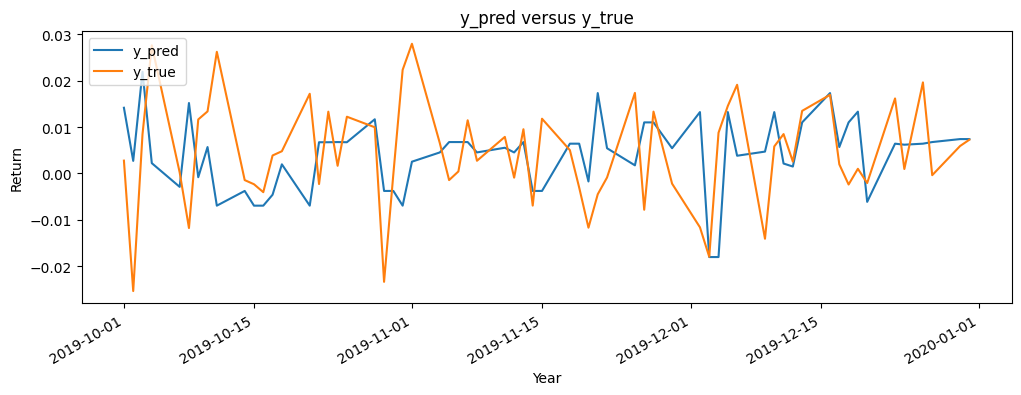

In [340]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)
y_pred = ml_model(X_train, y_train, X_test, y_test, ml_mod = KNeighborsRegressor())
plot_results(y_pred = y_pred, y_test = y_test)

By KNeighbors we can recognize at least some similar muster, but it is partly shifted into the future and accuracy score is low, so the performance it quite poor.

## Linear Regression

Accuracy of Stock Prediction: -12.47 %


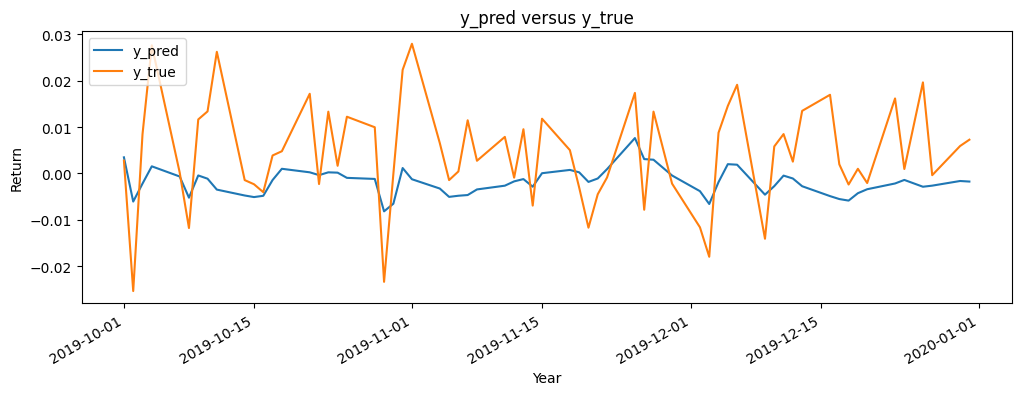

In [341]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

y_pred = ml_model(X_train, y_train, X_test, y_test, scal = RobustScaler(), ml_mod = linear_model.LinearRegression())
plot_results(y_pred = y_pred, y_test = y_test)

Linear Regression is slightly better then KNeighbors as up to accuracy score, but it is still low. The line of the predicted values also looks much more flat than true returns.

## Ridge Regression

Accuracy of Stock Prediction: -2.19 %


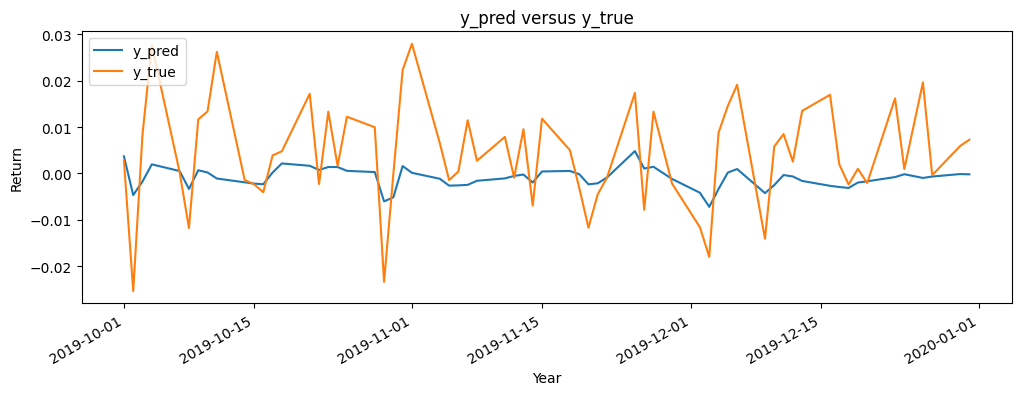

In [342]:
X_train, y_train, X_test, y_test = test_train_split(ml_df, "2014-01-01", "2019-09-30", "2019-10-01", "2020-01-01", features)

y_pred = ml_model(X_train, y_train, X_test, y_test, scal = RobustScaler(), ml_mod = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv = tscv))

plot_results(y_pred = y_pred, y_test = y_test)

Similar performance as by Linear Regression, but the accuracy rate is still too low.



# Results
## Model Evaluation and Validation

In my research, I tried to predict stock prices movements. For that,  I used different Machine Learning models. Classification models seem to deliver very resilts with high predictive power of up to 70% on if a stock price is going to grow or fall the next days. Model that delivered the best results was Random Forest Classifier. I got really great results using trading parameters (MACD and Signal, Rolling Mean and standard deviation, RSI and Williams %R), that already according to their visualisation looked promising to predict price movements. It turned out that longer time periods doesnt contribute to higher predicive power of the model. Also just taking laged values of returnes doest make the predictions better. It also goes hand in hand with the fact that KNeighborsRegressor, Linear Regression, Ridge Regression models didnt work for predictions.

## Difficulties that I accounted during my project

One of the difficulties I had,  that historical data was given better accuracy results then recent data, becuase recent data is more volatile. Another difficulty I had is regarding to content. I had to so some research and found a lot of sources explaining how stock market works and how to calculate some trading parameter (including Machine Learning source for trading, suggested by Udacity, that was interesting and expanded my understanding of stock market https://www.udacity.com/course/machine-learning-for-trading--ud501), but I didn't find any good source explaining which machine learning models are best to use for trading. I tried a lot of diffrent models, but most of them gave bad accuracy results,  I found a lot of tries but none of them demonstrated good performance or was explained why one works better than another. Even in books for machine learning I couldnt find it. And the last thing that was difficult is to stop trying more and more new models using more and more datasets :)

## Improvements

My work showed that the most important is to choose right data that really can explain the variable of interest. So as futher improvements I suggest searching for more features, that have relevance for explanaition of stock prices. I would be also great to check the model on bigger variaty of different stocks. And last but not least it would be great to find some model that not only predicts if stock price goes up or down but also the value of this movement. Moreover, I think it would be a great idea to write a code, using e.g. NLP, ARIMA and othe ML models. Also, we can perform tuning of its parameters and tha will help us to increase predictive power(number of trees, minimum number of features to consider when looking for the best split and required to split an internal node, maximum depth of the tree and if or nor using Bootstraping).